In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

from scipy.signal import peak_prominences, find_peaks, wiener, savgol_filter

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings("ignore")

Наша задача состоит в том, чтобы предсказать количество открытых ионных каналов в каждый момент времени измерения электрического сигнала для некоторой тестовой выборки, для которой измерено значение сигнала. По сути это задача предсказания таргета для момента времени $t$ по двум признакам $x_1$ и $x_2$, где $x_1$ - ряд значений сигнала на данном датасете и $x_2 = t$ - метка текущего времени. Заметим, что для одного датасета значение $x_1$ у всех моментов времени, для которых мы делаем предсказание, одинаково. Как видно из этого описания, в задаче будут применяться методы, характерные как для классического машинного обучения, так и для предсказания временных рядов(хотя наша задача и не является timeseries forecasting, но она имеет с ней некоторые схожести).

Считаем тренировочные данные. Так как на самом деле в таблице 10 временных рядов, то сразу разобьем данные на 10 частей.

In [2]:
train_data = pd.read_csv('train.csv', index_col=0)
train_data.head()

,signal,open_channels
time,,
0.0001,-2.7600,0
0.0002,-2.8557,0
0.0003,-2.4074,0
0.0004,-3.1404,0
0.0005,-3.1525,0


In [3]:
new_data = []
for i in range(10):
    cur_data = train_data.iloc[(len(train_data) // 10) * i: (len(train_data) // 10) * (i + 1)]
    cur_data.index = train_data.index[: len(train_data) // 10]
    new_data.append(cur_data)
    
train_data = new_data

Посмотрим на наши данные:

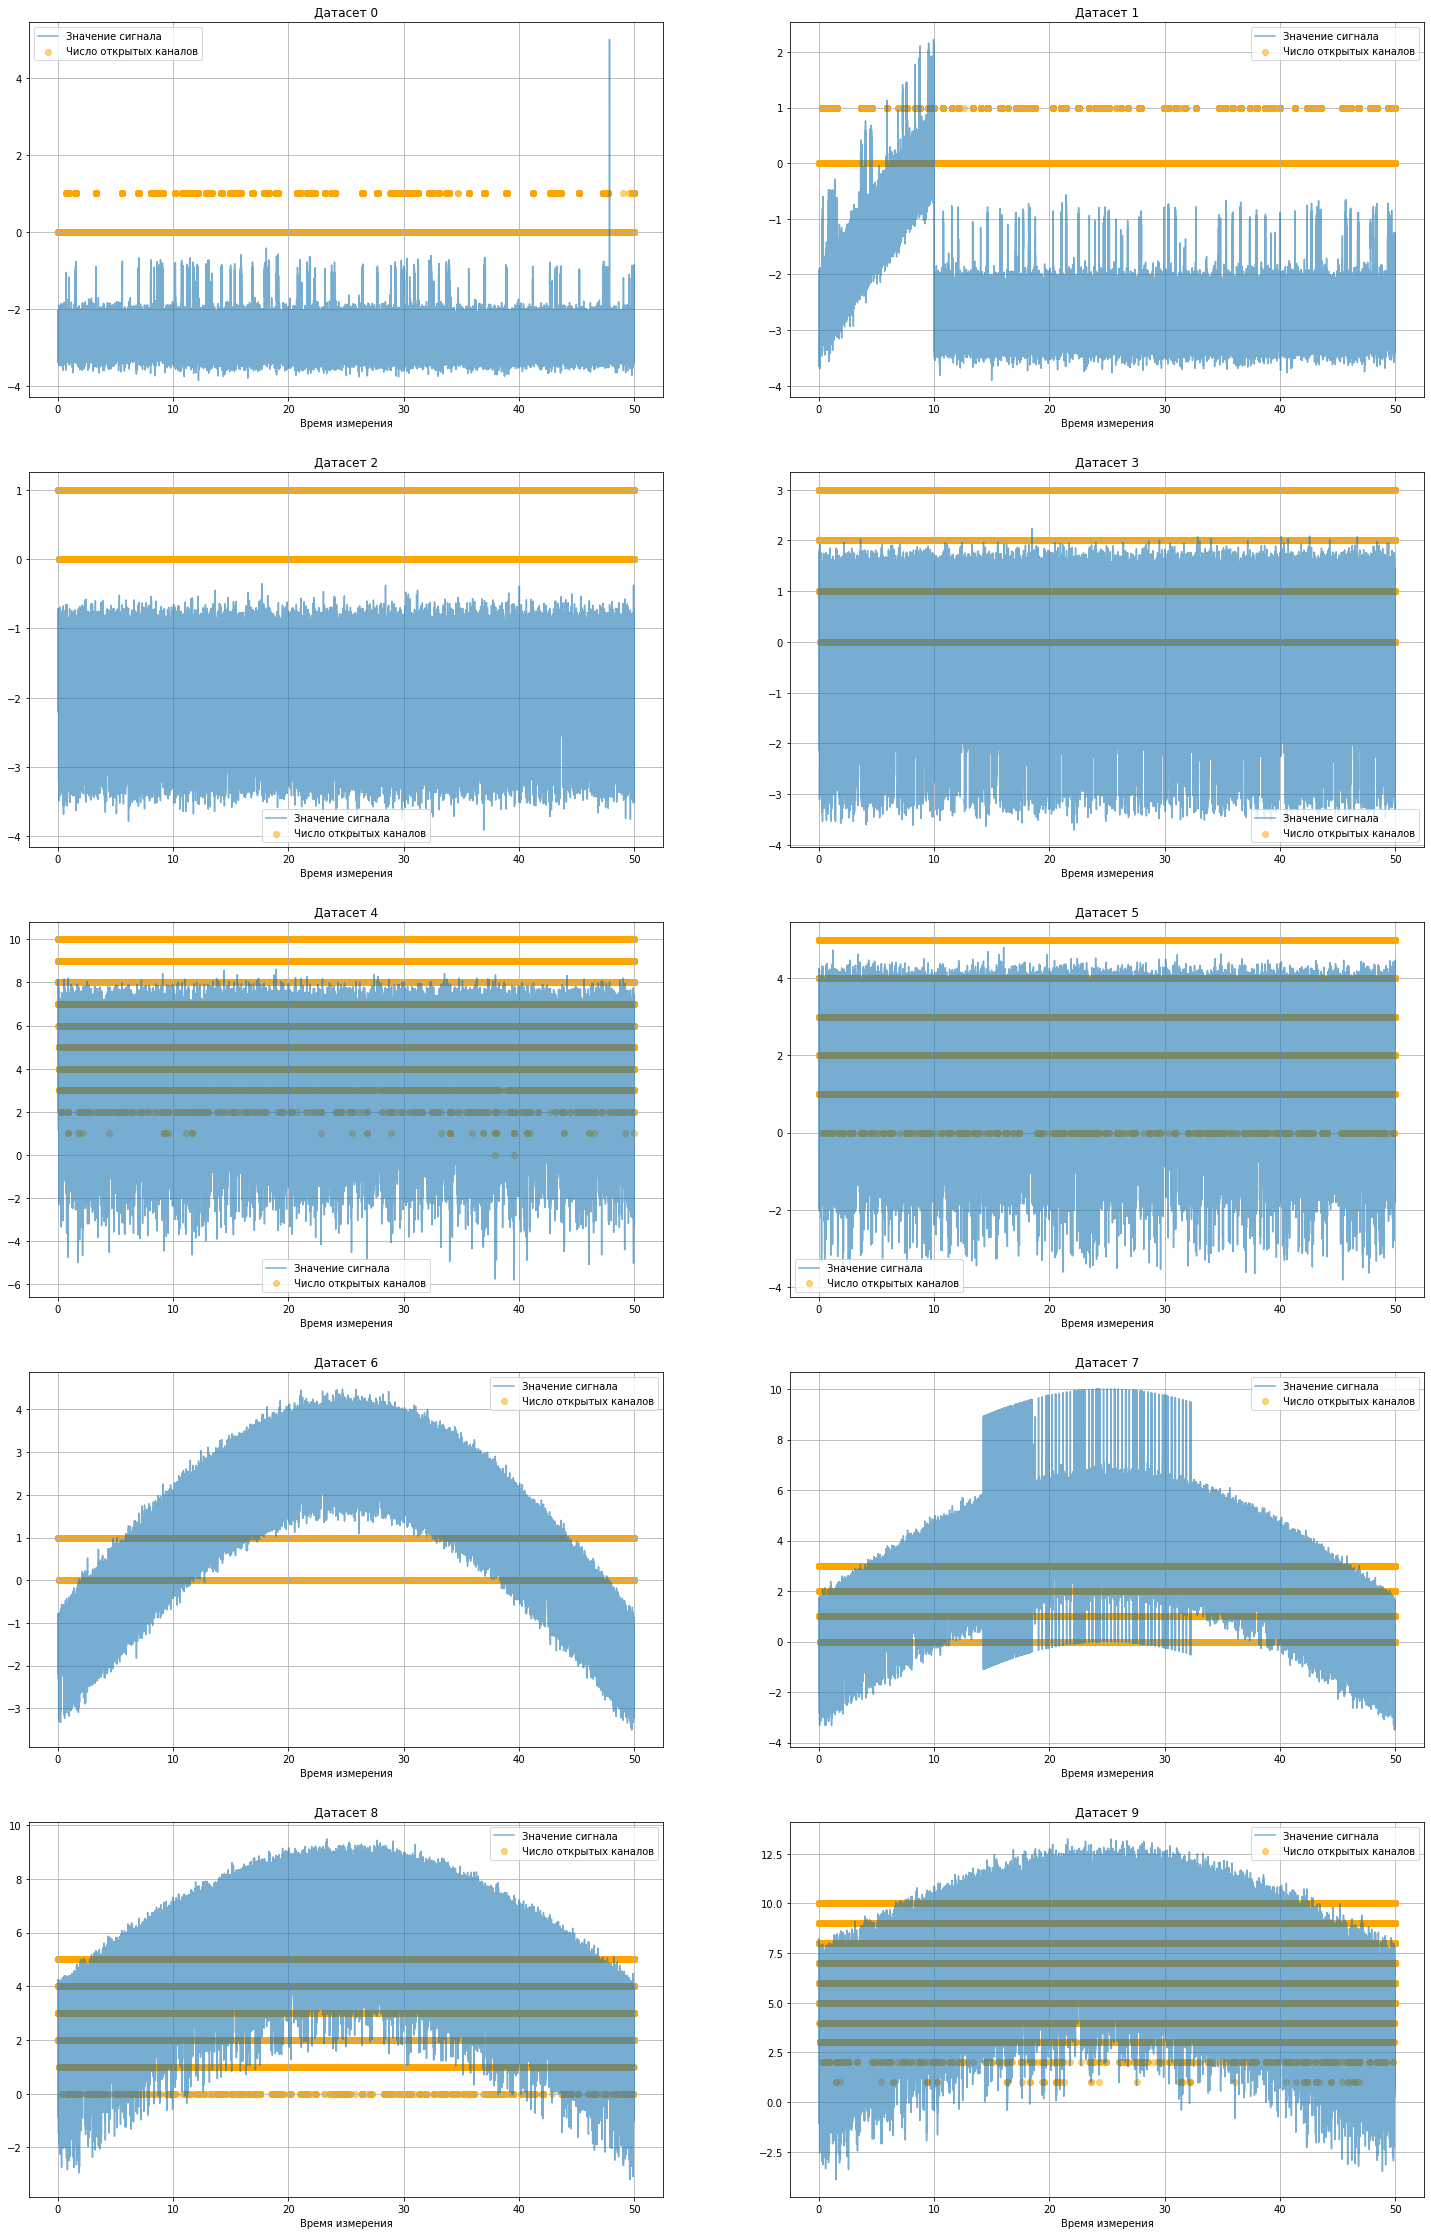

In [4]:
plt.figure(figsize=(25, 40))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    
    plt.scatter(train_data[i].index,
                train_data[i]['open_channels'], 
                c='orange', alpha=0.5, label='Число открытых каналов')
    plt.plot(train_data[i].index,
             train_data[i]['signal'],
             alpha=0.6, label='Значение сигнала')


    plt.xlabel('Время измерения')
    plt.title(f'Датасет {i}')
    plt.grid()
    plt.legend()
plt.show()

Мы можем видеть по графикам, что число открытых ионных каналов может колебаться от 0 до 10. Cтоит заметить, что сами величины сигнала очень по-разному ведут себя для разных датасетов. Тут мы видим и нечто напоминающее синусоиду, как в датасетах 6-9, и сплошные полосы, как в датасетах 0 и 2-5, и какие-то комбинации полос, как для датасета 1. В описании задачи сказано, что к данным добавлен шум. Судя по всему, именно он является причиной формы графиков, отличной от сплошной полосы.
 
Стоит заметить, что измерений у нас очень много, и использование визуального анализа полных датасетов в нашей задаче затруднительно. Поэтому давайте рассмотрим только части графиков.

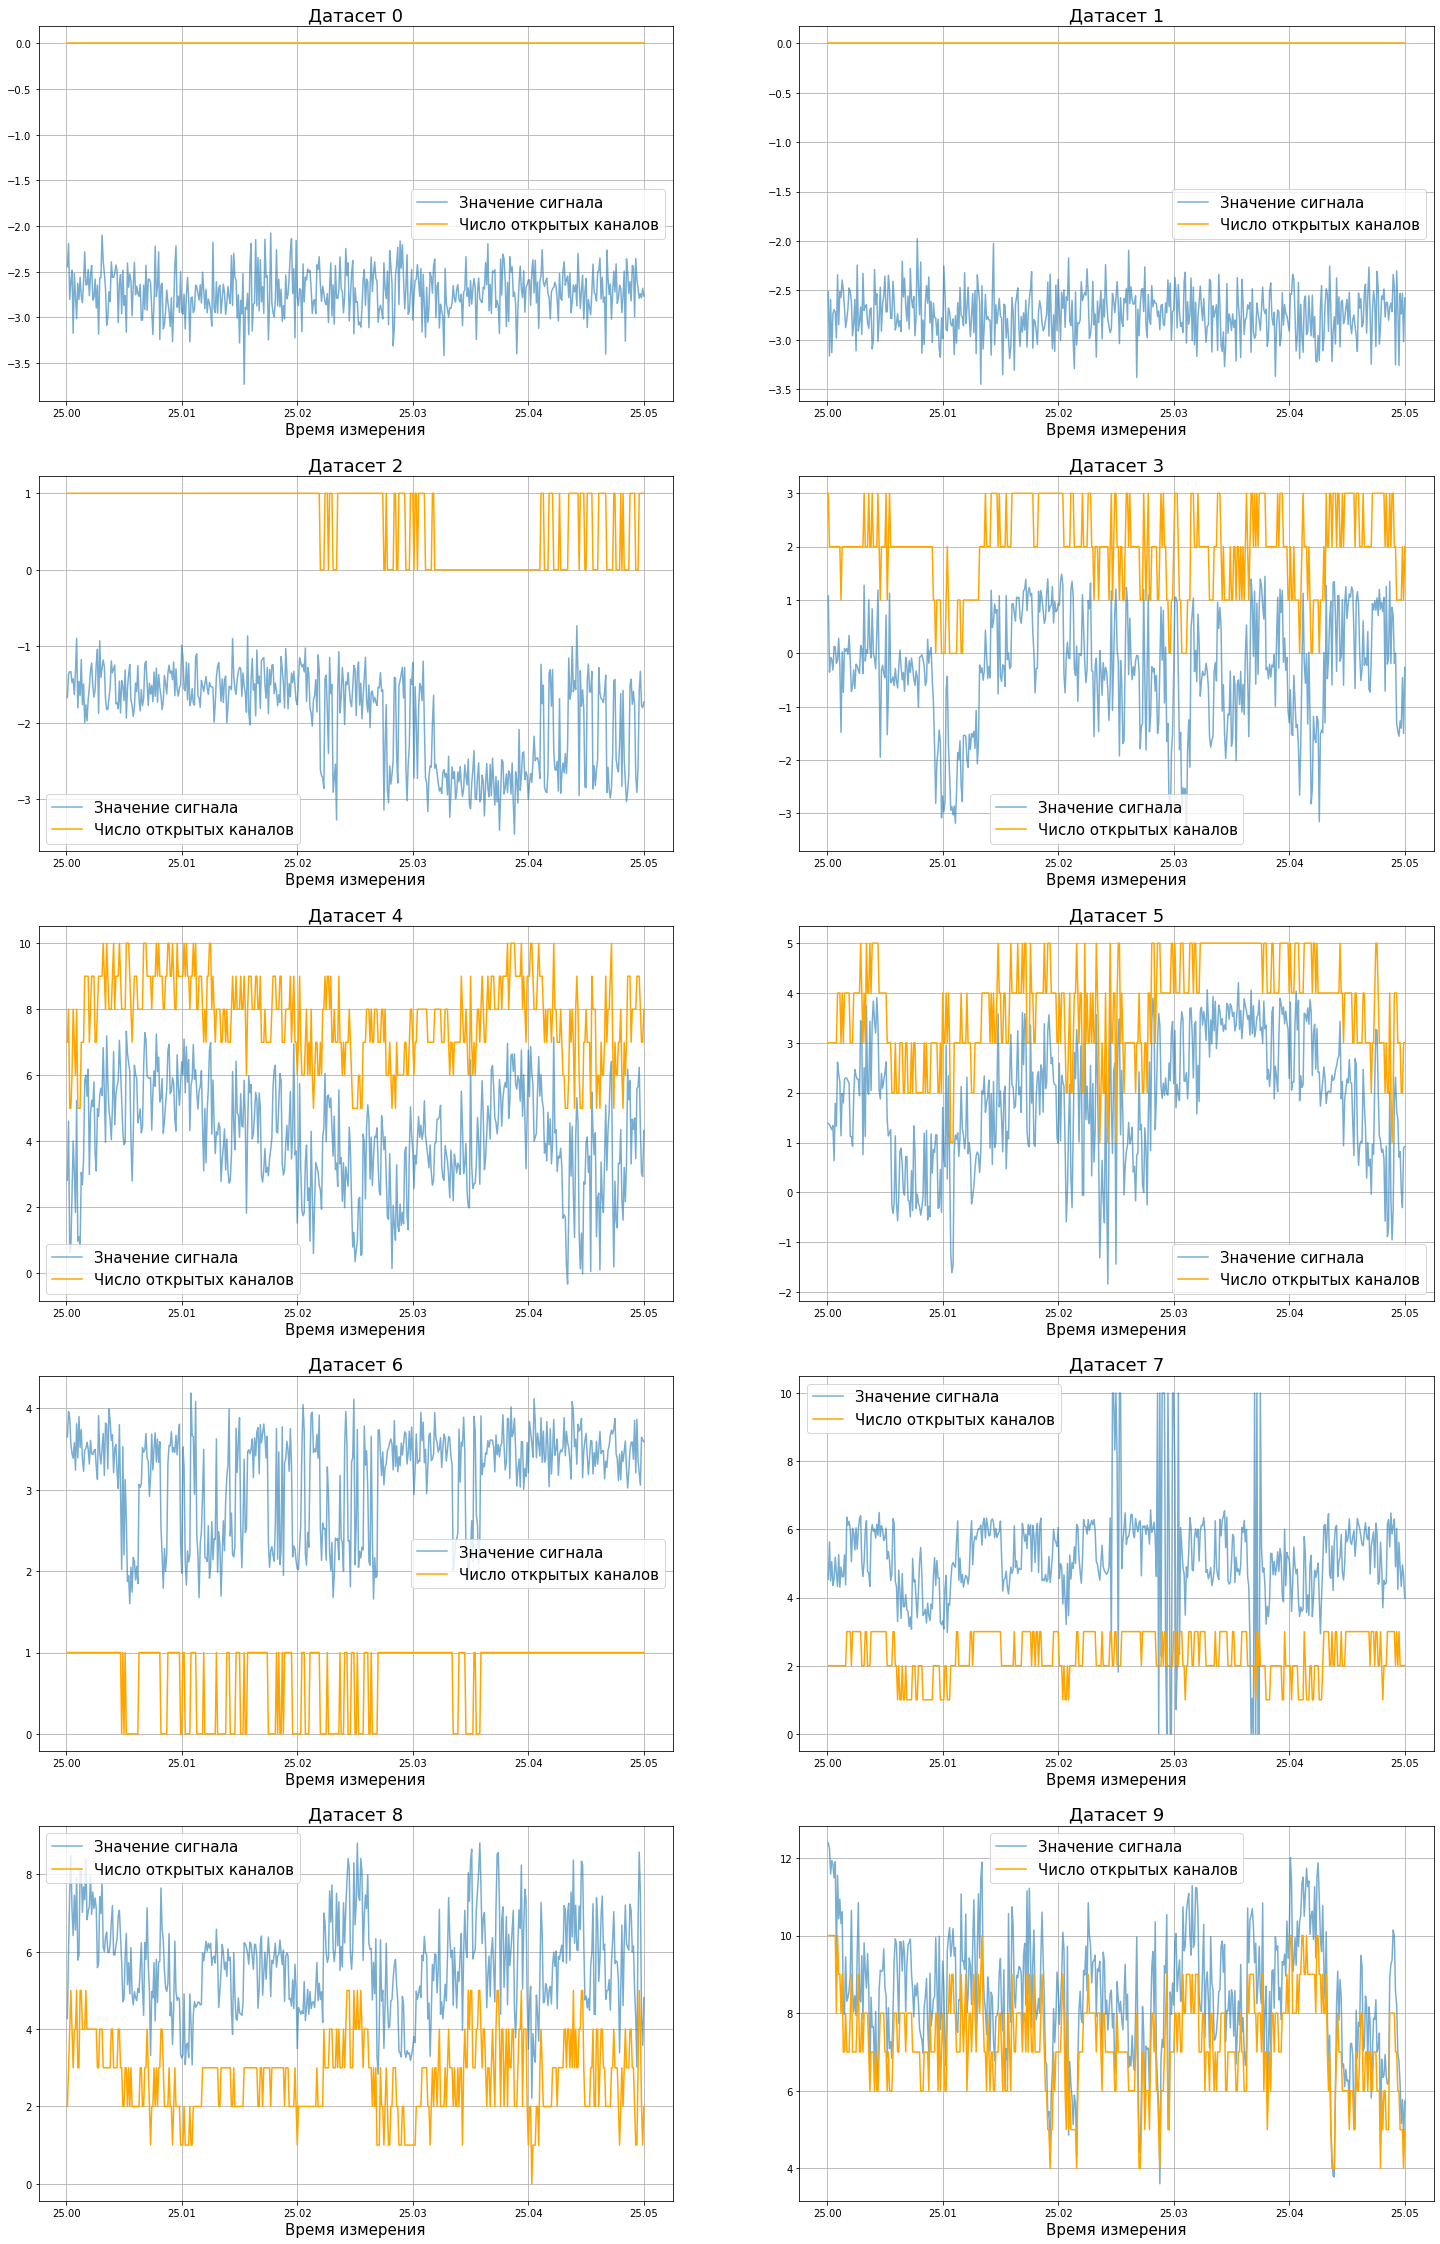

In [5]:
plt.figure(figsize=(25, 40))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    
    plt.plot(train_data[i].index[250000: 250500],
             train_data[i]['signal'].iloc[250000: 250500],
             alpha=0.6, label='Значение сигнала')
    plt.plot(train_data[i].index[250000: 250500],
             train_data[i]['open_channels'].iloc[250000: 250500], 
             c='orange', label='Число открытых каналов')

    plt.xlabel('Время измерения', fontsize=15)
    plt.title(f'Датасет {i}', fontsize=18)
    plt.grid()
    plt.legend(prop={'size': 15})
plt.show()

Судя по графикам, величина сигнала довольно сильно коррелирует с числом открытых каналов. Поэтому можно попробовать делать предсказания с помощью обычных моделей машинного обучения с одним признаком - величиной сигнала. Однако для разных датасетов эти модели, судя по всему, должны будут различаться, так как, например, для датасета 9 зависимость таргета от сигнала видна очень явно, а в датасете 0, где практически всегда таргет равен 0, зависимость более сложная.

Для изучения распределения таргета построим гистограммы числа открытых каналов для разных датасетов.

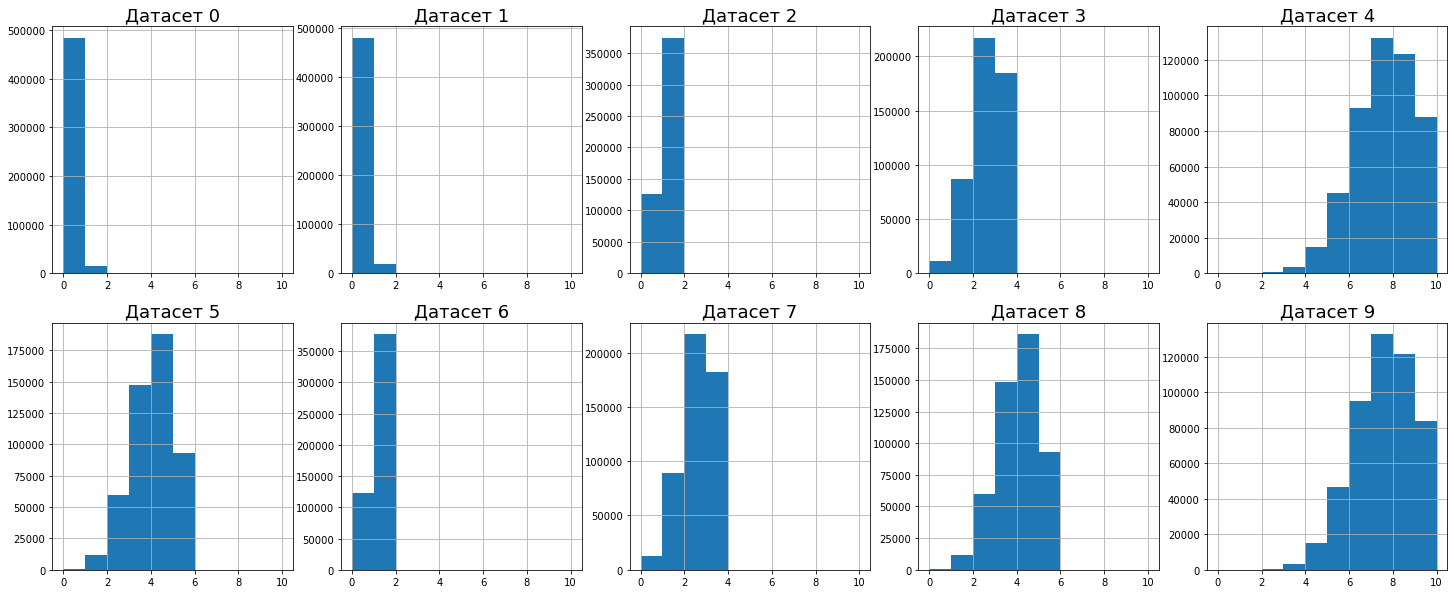

In [6]:
plt.figure(figsize=(25, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    plt.hist(train_data[i]['open_channels'], bins=np.arange(11))
    plt.title(f'Датасет {i}', fontsize=18)
    plt.grid()
plt.show()

Можно заметить одну странную особенность: некоторые гистограммы практически совпадают(0 и 1, 2 и 6, 5 и 8, 3 и 7, 4 и 9).

Теперь давайте рассмотрим тестовый датасет.

In [5]:
test_data = pd.read_csv('test.csv', index_col=0)
test_data.head()

,signal
time,
500.0001,-2.6498
500.0002,-2.8494
500.0003,-2.8600
500.0004,-2.4350
500.0005,-2.6155


In [7]:
test_data_index = test_data.index.values

In [8]:
new_data = []
for i in range(4):
    cur_data = test_data.iloc[(len(test_data) // 4) * i: (len(test_data) // 4) * (i + 1)]
    cur_data.index = train_data[0].index
    new_data.append(cur_data)
    
test_data = new_data

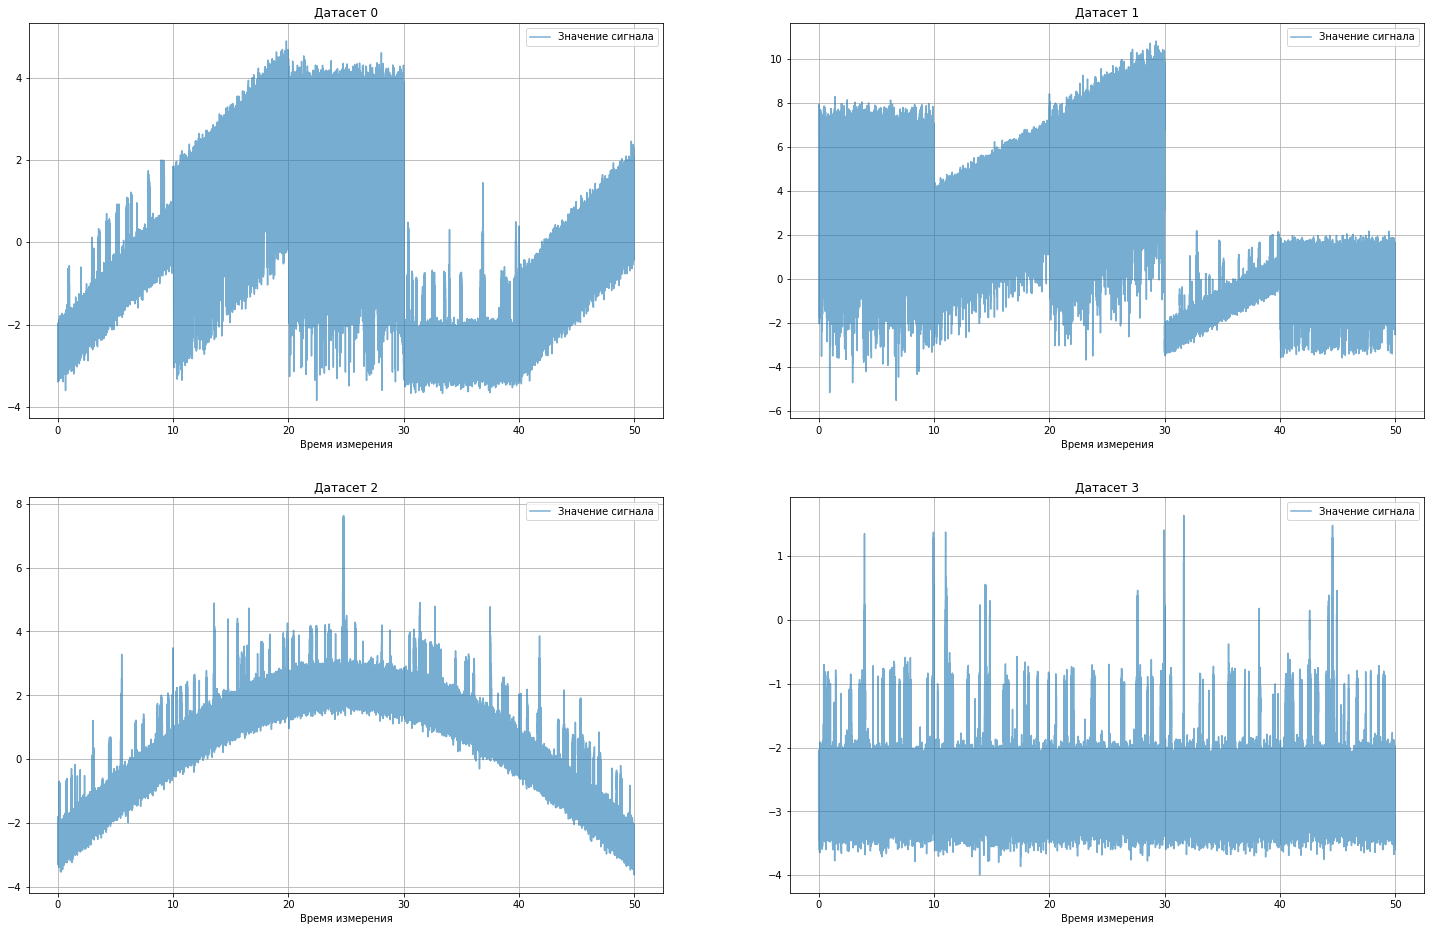

In [9]:
plt.figure(figsize=(25, 16))

for i in range(4):
    plt.subplot(2, 2, i + 1)

    plt.plot(test_data[i].index,
             test_data[i]['signal'],
             alpha=0.6, label='Значение сигнала')

    plt.xlabel('Время измерения')
    plt.title(f'Датасет {i}')
    plt.grid()
    plt.legend()
plt.show()

Здесь в первых трех датасетах мы видим траектории, похожие на добавленный шум.

**1. Удаление шума**

Так как мы увидели, что таргет и значение сигнала хорошо коррелируют, то мы можем использовать это, но придется избавиться от шума(например, в 1 датасете мы видим, что при резком изменении сигнала число каналов никак не меняется, то есть, скорее всего, тут имеем дело с добавленным шумом).

Еще раз посмотрим на траектории значения сигнала для трейна.

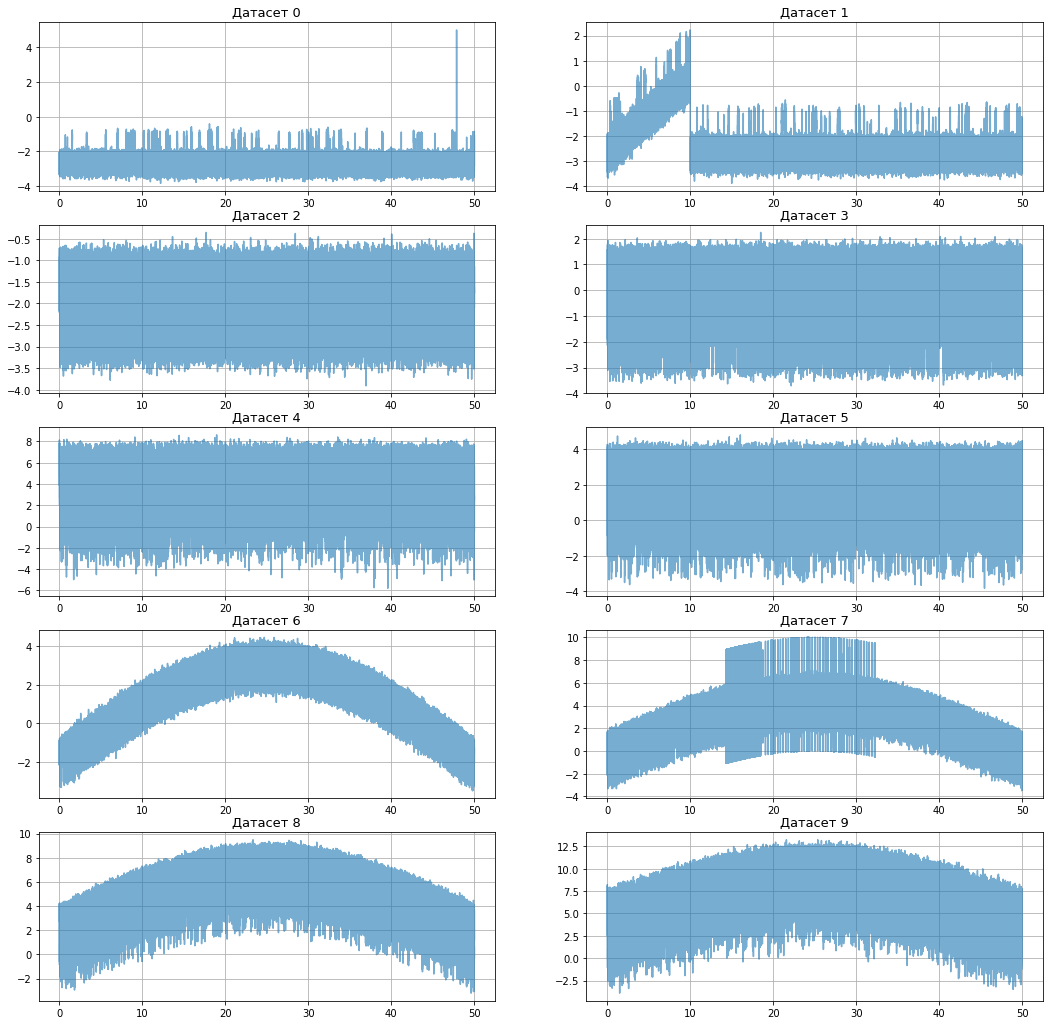

In [8]:
plt.figure(figsize=(18, 18))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    
    plt.plot(train_data[i].index,
             train_data[i]['signal'],
             alpha=0.6)

    plt.title(f'Датасет {i}', fontsize=13)
    plt.grid()
plt.show()

Попробуем подобрать такие преобразования этих данных, чтобы графики сигнала стали похожи на сплошную полосу.

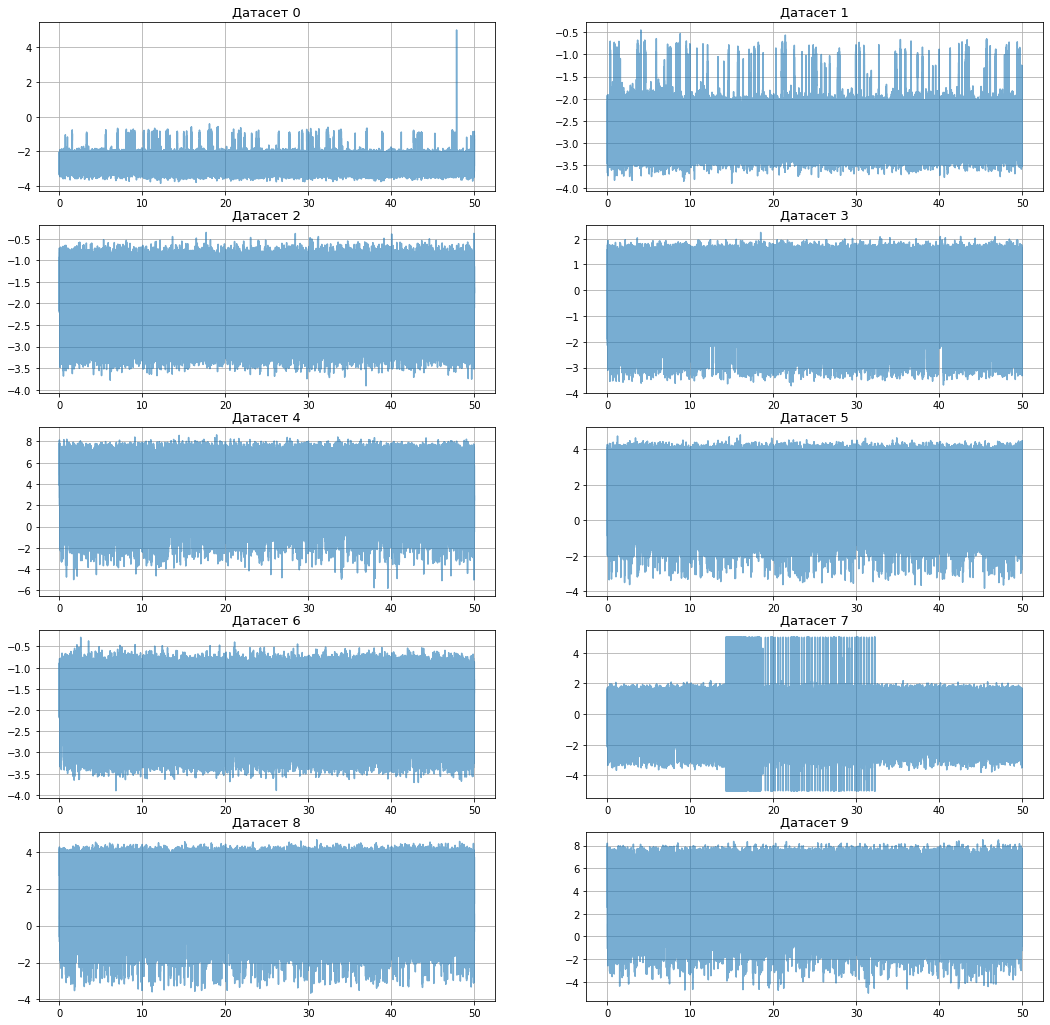

In [9]:
train_data_copy = [train_data[i].copy() for i in range(10)]

train_data_copy[1].loc[:10, 'signal'] -= 0.3 * train_data_copy[1].loc[:10].index.values
train_data_copy[6]['signal'] -= 5 * np.sin(train_data_copy[6].index.values * np.pi / 50)
train_data_copy[7]['signal'] -= 5 * np.sin(train_data_copy[7].index.values * np.pi / 50)
train_data_copy[8]['signal'] -= 5 * np.sin(train_data_copy[8].index.values * np.pi / 50)
train_data_copy[9]['signal'] -= 5 * np.sin(train_data_copy[9].index.values * np.pi / 50)

plt.figure(figsize=(18, 18))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    
    plt.plot(train_data_copy[i].index,
             train_data_copy[i]['signal'],
             alpha=0.6)

    plt.title(f'Датасет {i}', fontsize=13)
    plt.grid()
plt.show()

Итак, чистка произведена. Учитывая, что для последних 4 графиков пришлось вычесть одинаковые функции для приведения их в адекватный вид, мы еще сильнее убеждаемся в том, что это был действительно добавленный шум. Врядли такое совпадение могло произойти случайно.

In [10]:
train_data = train_data_copy

Сделаем то же самое для теста:

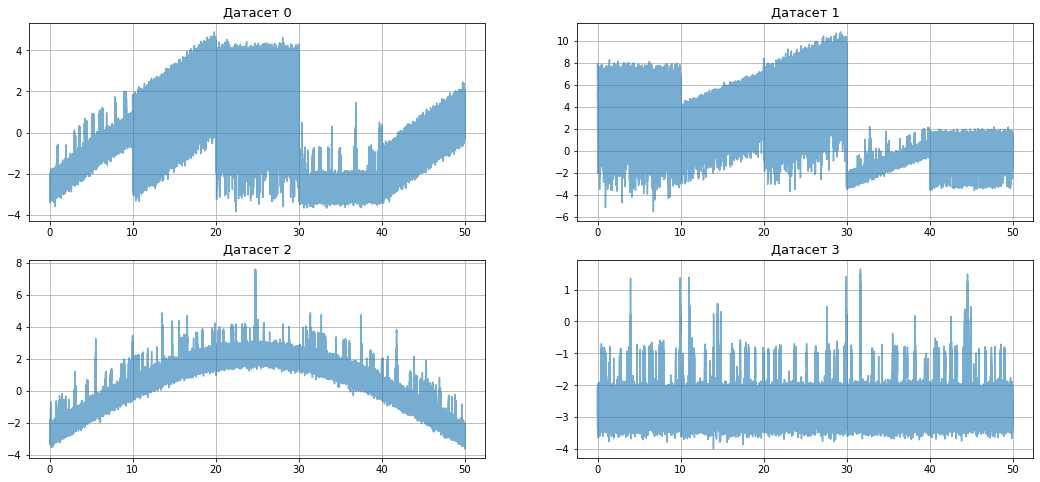

In [11]:
plt.figure(figsize=(18, 8))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    plt.plot(test_data[i].index,
             test_data[i]['signal'],
             alpha=0.6)

    plt.title(f'Датасет {i}', fontsize=13)
    plt.grid()
plt.show()

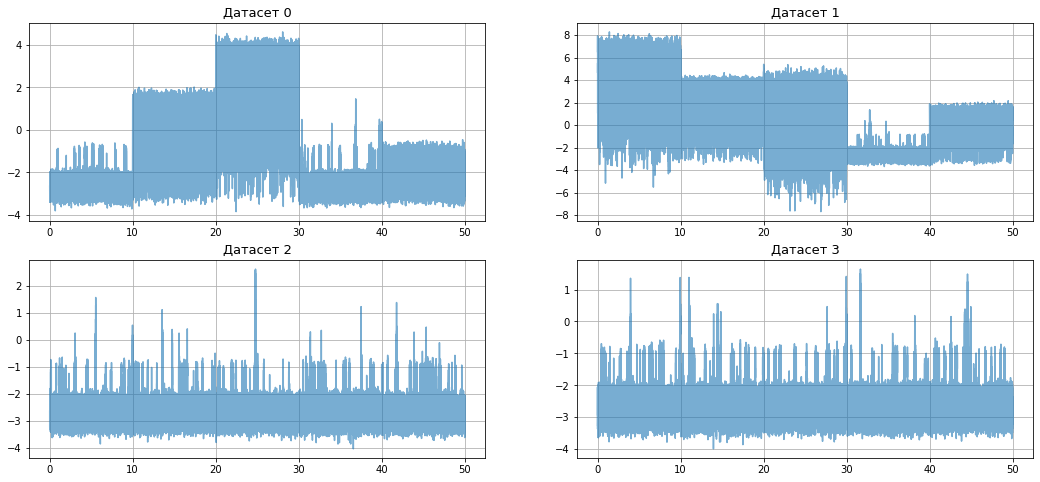

In [12]:
test_data_copy = [test_data[i].copy() for i in range(4)]

test_data_copy[0].loc[:10, 'signal'] -= 0.3 * test_data_copy[0].loc[:10].index.values
test_data_copy[0].loc[10:20, 'signal'] -= 0.3 * (test_data_copy[0].loc[10:20].index.values - 10)
test_data_copy[0].loc[40:, 'signal'] -= 0.3 * (test_data_copy[0].loc[40:].index.values - 40)

test_data_copy[1].loc[10:30, 'signal'] -= 0.3 * (test_data_copy[1].loc[10:30].index.values - 10)
test_data_copy[1].loc[30:40, 'signal'] -= 0.3 * (test_data_copy[1].loc[30:40].index.values - 30)

test_data_copy[2]['signal'] -= 5 * np.sin(test_data_copy[2].index.values * np.pi / 50)


plt.figure(figsize=(18, 8))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    plt.plot(test_data_copy[i].index,
             test_data_copy[i]['signal'],
             alpha=0.6)

    plt.title(f'Датасет {i}', fontsize=13)
    plt.grid()
plt.show()

Здесь так же по сути мы вычитали одну и ту же функцию, чтобы привести графики в надлежащий вид. Врядли это совпадение.

Если посмотреть на график для 0-го тестового датасета, то можно увидеть, что он представляет из себя совокупность нескольких сплошных полос. Встает вопрос: не нужно ли эти полосы сместить и отнормировать, чтобы весь график был одной сплошной полосой. Чтобы узнать ответ на этот вопрос, мы могли бы обратиться к совместному графику числа открытых каналов и значения сигнала. Если в районах смены полос будет сильное изменение таргета, то из соображений уже отмеченной выше корреляции таргета и сигнала, мы оставим все как есть. Но, к сожалению, мы не знаем таргет для теста и не сможем проделать это. А на трейне подобной проблемы не наблюдается. Обсудим этот момент позже.

In [13]:
test_data = test_data_copy

**2. Предсказание по одному признаку. Модели классического ML. Одна модель для всех данных.**

Так как мы выяснили, что есть неплохая корреляция между сигналом и числом каналов, давайте предсказывать число каналов просто по значению сигнала.

In [17]:
X = np.concatenate([train_data[i]['signal'].values for i in range(10)])
Y = np.concatenate([train_data[i]['open_channels'].values for i in range(10)])

X_test = np.concatenate([test_data[i]['signal'].values for i in range(4)])

Давайте построим линейный классификатор - многоклассовую логистическую регрессию.

In [182]:
model = LogisticRegression()
model.fit(X[:, np.newaxis], Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [183]:
predictions = model.predict(X_test[:, np.newaxis])

In [184]:
f = lambda x: '{:,.4f}'.format(x)
vf = np.vectorize(f)

ans = pd.DataFrame({'time': vf(test_data_index),
                    'open_channels': predictions.astype('int32')})

ans.to_csv('ion_v4.csv', index=False)

Мы получили скор = 0.278

Теперь попробуем использовать случайный лес.

In [25]:
%%time
model = RandomForestClassifier(n_estimators=10)
model.fit(X[:, np.newaxis], Y)

Wall time: 5min 21s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
f = lambda x: '{:,.4f}'.format(x)
vf = np.vectorize(f)

ans = pd.DataFrame({'time': vf(test_data_index),
                    'open_channels': predictions.astype('int32')})

ans.to_csv('ion_v6.csv', index=False)

Мы получили скор = 0.465.

**3. Предсказание по одному признаку. Модели классического ML. Несколько моделей для разных данных.**

Я уже заметил выше про одинаковость распределений для пар трейновых датасетов. Это наталкивает на мысли о наличии некоторых закономерностей в парных датасетах. Давайте еще раз повнимательнее взглянем на графики для них. 

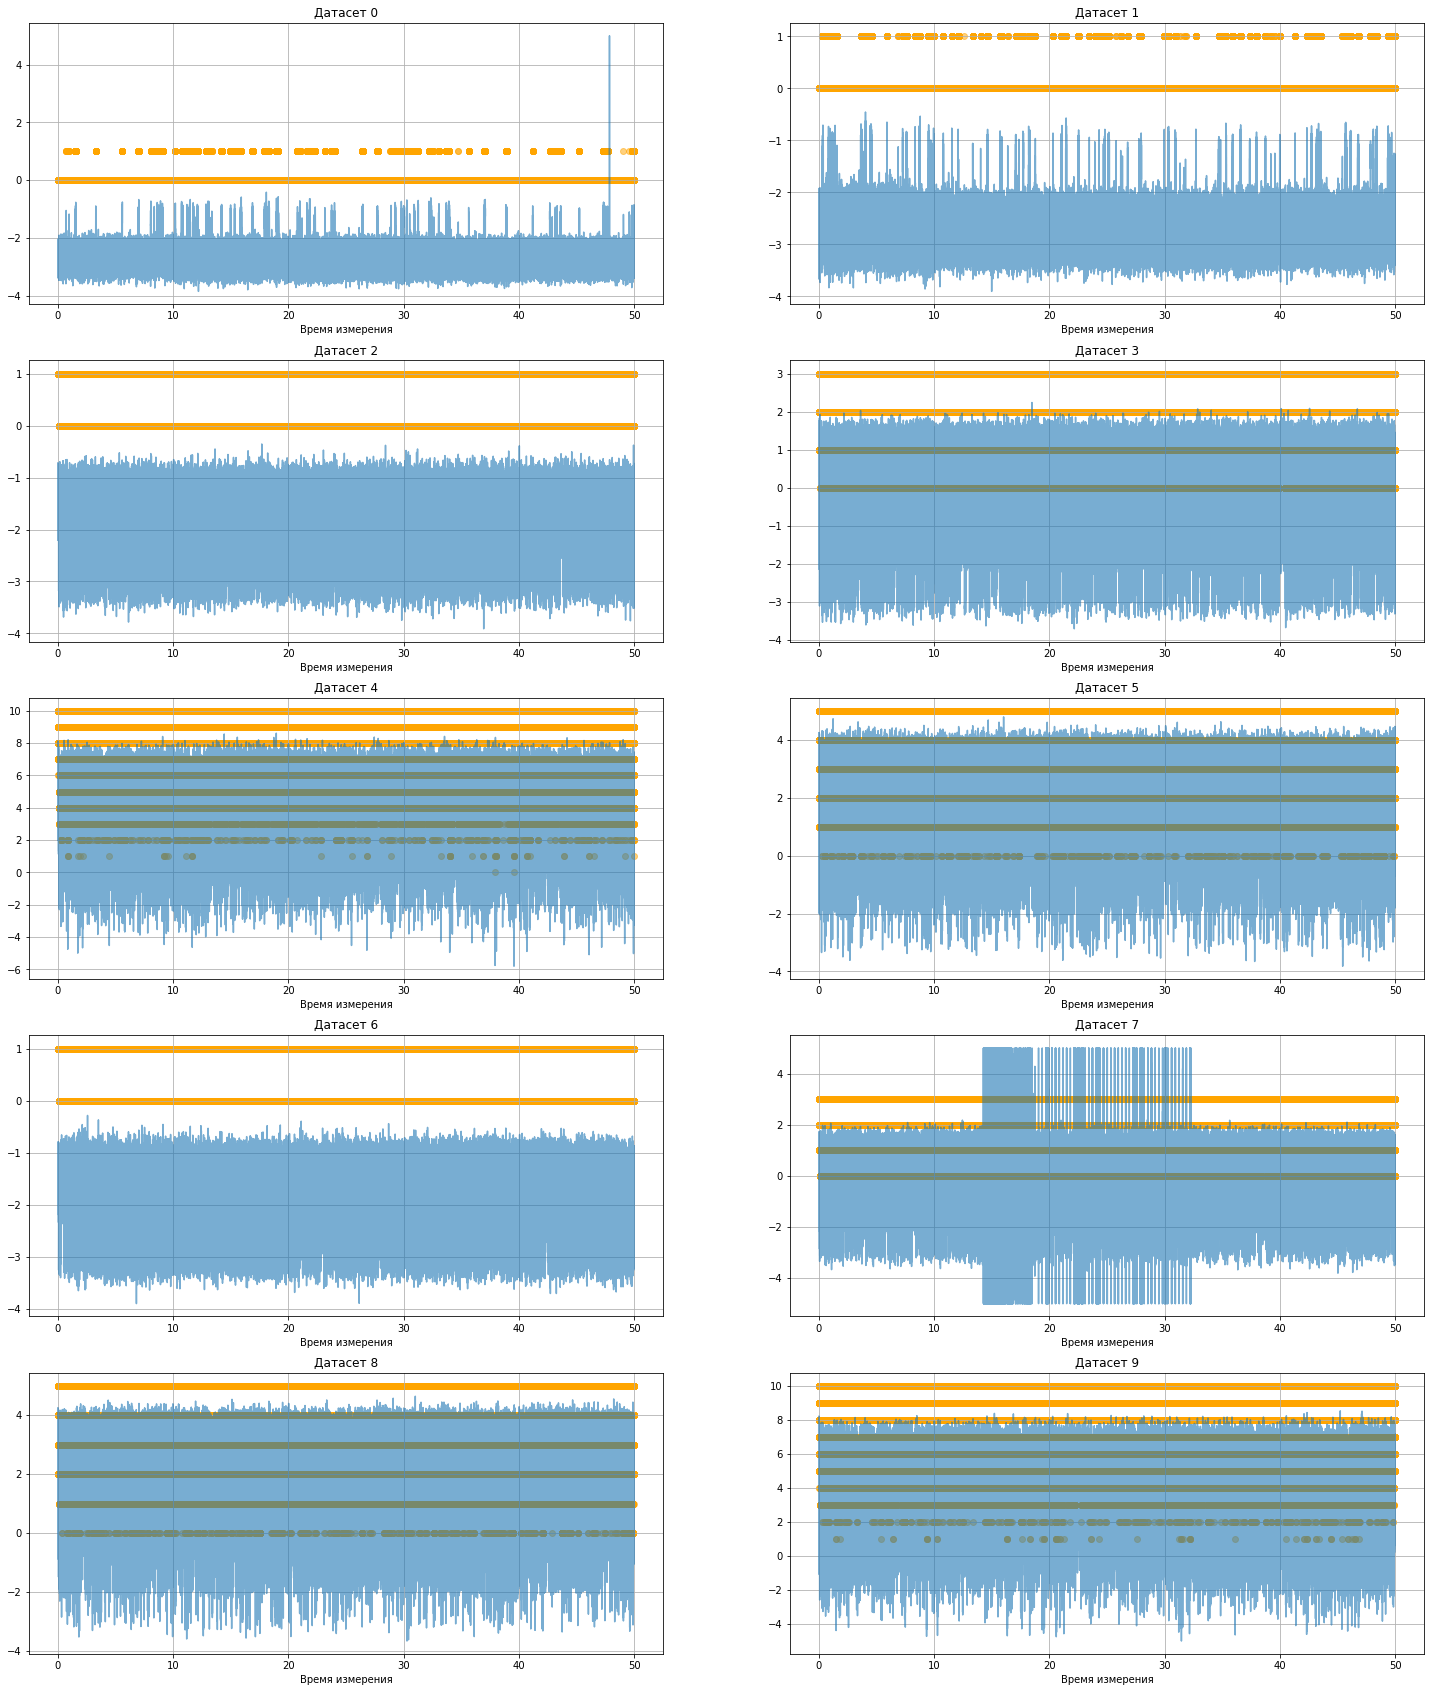

In [24]:
plt.figure(figsize=(25, 30))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    
    plt.scatter(train_data[i].index,
                train_data[i]['open_channels'], 
                c='orange', alpha=0.5)
    plt.plot(train_data[i].index,
             train_data[i]['signal'],
             alpha=0.6)


    plt.xlabel('Время измерения')
    plt.title(f'Датасет {i}')
    plt.grid()
plt.show()

Мы выделяли 5 пар датасетов с почти идентичными распределениями таргета. Напомню их: (0 и 1, 2 и 6, 5 и 8, 3 и 7, 4 и 9). Сейчас мы можем видеть, что и графики сигналов у парных датасетов очень похожи(координаты низа полосы и верха совпадают).

Теперь еще раз посмотрим на тестовые данные.

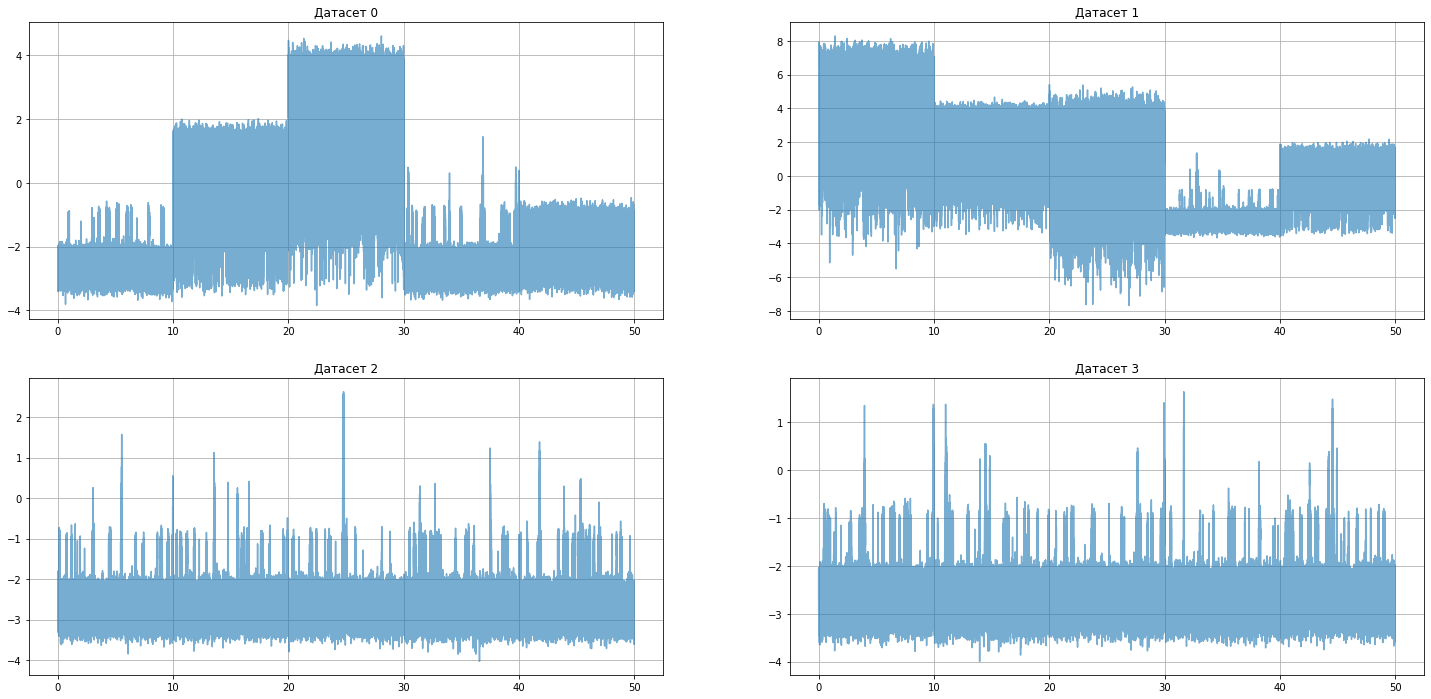

In [25]:
plt.figure(figsize=(25, 12))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    plt.plot(test_data[i].index,
             test_data[i]['signal'],
             alpha=0.6)

    plt.title(f'Датасет {i}')
    plt.grid()
plt.show()

Теперь если мы опять же посмотрим на координаты низа и верха полос, то придем к выводу, что для теста датасет 1 состоит из частей, соответствующих трейновым парам (0, 1); (3, 7); (5, 8); (0, 1); (2, 6) соответственно.
Датасет 2 состоит из частей, соответствующих трейновым парам (4, 9); (5, 8); (5, 8); (0, 1); (3, 7) соответственно.
Датасеты 3 и 4 состоят из частей, соответствующих трейновой паре (0, 1).

Мы выделили 5 типичных частей в наших данных. Давайте для каждой части обучим свою модель и применим их к соответствующим частям тестовых датасетов.

In [54]:
X = np.concatenate([train_data[0]['signal'].values, 
                    train_data[1]['signal'].values])
Y = np.concatenate([train_data[0]['open_channels'].values, 
                    train_data[1]['open_channels'].values])
model_1 = RandomForestClassifier(n_estimators=10)
model_1.fit(X[:, np.newaxis], Y)


X = np.concatenate([train_data[2]['signal'].values, 
                    train_data[6]['signal'].values])
Y = np.concatenate([train_data[2]['open_channels'].values, 
                    train_data[6]['open_channels'].values])
model_2 = RandomForestClassifier(n_estimators=10)
model_2.fit(X[:, np.newaxis], Y)


X = np.concatenate([train_data[3]['signal'].values, 
                    train_data[7]['signal'].values])
Y = np.concatenate([train_data[3]['open_channels'].values, 
                    train_data[7]['open_channels'].values])
model_3 = RandomForestClassifier(n_estimators=10)
model_3.fit(X[:, np.newaxis], Y)


X = np.concatenate([train_data[4]['signal'].values, 
                    train_data[9]['signal'].values])
Y = np.concatenate([train_data[4]['open_channels'].values, 
                    train_data[9]['open_channels'].values])
model_4 = RandomForestClassifier(n_estimators=10)
model_4.fit(X[:, np.newaxis], Y)


X = np.concatenate([train_data[5]['signal'].values, 
                    train_data[8]['signal'].values])
Y = np.concatenate([train_data[5]['open_channels'].values, 
                    train_data[8]['open_channels'].values])
model_5 = RandomForestClassifier(n_estimators=10)
model_5.fit(X[:, np.newaxis], Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [81]:
predictions = np.array([])

#датасет 0
X = test_data[0].loc[:10, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[10.0001:20, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_3.predict(X))

X = test_data[0].loc[20.0001:30, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_5.predict(X))

X = test_data[0].loc[30.0001:40, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[40.0001:, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_2.predict(X))

#датасет 1
X = test_data[1].loc[:10, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_4.predict(X))

X = test_data[1].loc[10.0001:30, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_5.predict(X))

X = test_data[1].loc[30.0001:40, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_1.predict(X))

X = test_data[1].loc[40.0001:, 'signal'].values[:, np.newaxis]
predictions = np.append(predictions, model_3.predict(X))

#датасеты 2 и 3
X = np.concatenate([test_data[2]['signal'].values,
                    test_data[3]['signal'].values])[:, np.newaxis]
predictions = np.append(predictions, model_1.predict(X))

In [82]:
f = lambda x: '{:,.4f}'.format(x)
vf = np.vectorize(f)

ans = pd.DataFrame({'time': vf(test_data_index),
                    'open_channels': predictions.astype('int32')})

ans.to_csv('ion_v7.csv', index=False)

Мы получили скор = 0.920 - отличное улучшение.

**4. Предсказание по нескольким признакам. Модели классического ML**

Мы видели, что число каналов увеличивается, когда мы наблюдаем пики значения сигналов, и наоборот. Чтобы как-то получать информацию о характерах пиков и не только, давайте будем использовать для данного момента времени информацию о значениях сигнала в другие моменты времени и среднее значение сигнала в окрестности нашей текущей точки.

In [15]:
def PrepareData(arr, before=3, after=3):
    cols = [f'signal diff {i}' for i in range(-before, after + 1)]

    new_data = pd.DataFrame(index=np.arange(len(arr)))
    
    arr1 = np.append(np.array([False]), (arr[1:] - arr[:-1]) > 0)
    arr2 = np.append((arr[:-1] - arr[1:]) > 0, np.array([False]))
    arr3 = np.logical_and(arr1, arr2)
    arr3[0] = (arr[0] > arr[1])
    arr3[-1] = (arr[-1] > arr[-2])
    new_data['is_loc_max'] = arr3.astype('int32')

    arr1 = np.append(np.array([False]), (arr[1:] - arr[:-1]) < 0)
    arr2 = np.append((arr[:-1] - arr[1:]) < 0, np.array([False]))
    arr3 = np.logical_and(arr1, arr2)
    arr3[0] = (arr[0] < arr[1])
    arr3[-1] = (arr[-1] < arr[-2])
    new_data['is_loc_min'] = arr3.astype('int32')
        
    for j in range(1, before + 1):
        arr1 = np.repeat(-99999, j)
        arr2 = arr[j:] - arr[:-j]
        cur_arr = np.concatenate([arr1, arr2])
        new_data[f'signal diff {-j}'] = cur_arr
    
    new_data[f'signal diff {0}'] = arr

    for j in range(1, after + 1):
        arr1 = np.repeat(-99999, j)
        arr2 = arr[:-j] - arr[j:]
        cur_arr = np.concatenate([arr2, arr1])
        new_data[f'signal diff {j}'] = cur_arr
    
    new_data['mean_neib'] = new_data[cols].values.mean(axis=1)
    return new_data

Попробуем использовать XGBClassifier:

In [17]:
X = np.concatenate([train_data[0]['signal'].values, 
                    train_data[1]['signal'].values])
X = PrepareData(X)
Y = np.concatenate([train_data[0]['open_channels'].values, 
                    train_data[1]['open_channels'].values])
model_1 = XGBClassifier(n_estimators=100, max_depth=6)
model_1.fit(X, Y)
print('model_1: ready')


X = np.concatenate([train_data[2]['signal'].values, 
                    train_data[6]['signal'].values])
X = PrepareData(X)
Y = np.concatenate([train_data[2]['open_channels'].values, 
                    train_data[6]['open_channels'].values])
model_2 = XGBClassifier(n_estimators=100, max_depth=6)
model_2.fit(X, Y)
print('model_2: ready')


X = np.concatenate([train_data[3]['signal'].values, 
                    train_data[7]['signal'].values])
X = PrepareData(X)
Y = np.concatenate([train_data[3]['open_channels'].values, 
                    train_data[7]['open_channels'].values])
model_3 = XGBClassifier(n_estimators=100, max_depth=6)
model_3.fit(X, Y)
print('model_3: ready')


X = np.concatenate([train_data[4]['signal'].values, 
                    train_data[9]['signal'].values])
X = PrepareData(X)
Y = np.concatenate([train_data[4]['open_channels'].values, 
                    train_data[9]['open_channels'].values])
model_4 = XGBClassifier(n_estimators=100, max_depth=6)
model_4.fit(X, Y)
print('model_4: ready')


X = np.concatenate([train_data[5]['signal'].values, 
                    train_data[8]['signal'].values])
X = PrepareData(X)
Y = np.concatenate([train_data[5]['open_channels'].values, 
                    train_data[8]['open_channels'].values])
model_5 = XGBClassifier(n_estimators=100, max_depth=6)
model_5.fit(X, Y)
print('model_5: ready')

model_1: ready
model_2: ready
model_3: ready
model_4: ready
model_5: ready


In [18]:
predictions = np.array([])

#датасет 0
X = test_data[0].loc[:10, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[10.0001:20, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_3.predict(X))

X = test_data[0].loc[20.0001:30, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_5.predict(X))

X = test_data[0].loc[30.0001:40, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[40.0001:, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_2.predict(X))

#датасет 1
X = test_data[1].loc[:10, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_4.predict(X))

X = test_data[1].loc[10.0001:30, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_5.predict(X))

X = test_data[1].loc[30.0001:40, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[1].loc[40.0001:, 'signal'].values
X = PrepareData(X)
predictions = np.append(predictions, model_3.predict(X))

#датасеты 2 и 3
X = np.concatenate([test_data[2]['signal'].values,
                    test_data[3]['signal'].values])
X = PrepareData(X)
predictions = np.append(predictions, model_1.predict(X))

In [20]:
f = lambda x: '{:,.4f}'.format(x)
vf = np.vectorize(f)

ans = pd.DataFrame({'time': vf(test_data_index),
                    'open_channels': predictions.astype('int32')})

ans.to_csv('ion_v17.csv', index=False)

Мы получили скор = 0.938

Я также пробовал использовать случайный лес с разными параметрами, но результат был хуже.

Давайте проанализируем, какое качество показывают наши модели на трейновых датасетах.

In [23]:
ds_models_mapping = [model_1,
                     model_1,
                     model_2,
                     model_3, 
                     model_4, 
                     model_5, 
                     model_2, 
                     model_3,
                     model_5,
                     model_4]

In [25]:
for i, model in enumerate(ds_models_mapping):
    score = f1_score(train_data[i]['open_channels'].values,
                     model.predict(PrepareData(train_data[i]['signal'].values)), average="macro")
    print(f'DS {i} score: {score}')

DS 0 score: 0.9983564416932078
DS 1 score: 0.9982781394106872
DS 2 score: 0.9971377271926609
DS 3 score: 0.9861438050939039
DS 4 score: 0.911799085895537
DS 5 score: 0.977575361787215
DS 6 score: 0.9969667735771228
DS 7 score: 0.9607912153845996
DS 8 score: 0.9788832595702729
DS 9 score: 0.9018400464475903


Как видим, самые слабые предсказания мы получаем на 4 и 9 датасетах. Ранее на графиках мы видели, что именно они являются самыми разнообразными в плане значения числа открытых каналов. Чтобы делать более хорошие предсказания на этих данных, давайте поближе изучим ошибки, которые мы допускаем и попытаемся найти их причины. Анализ будем проводить на 4 датасете.

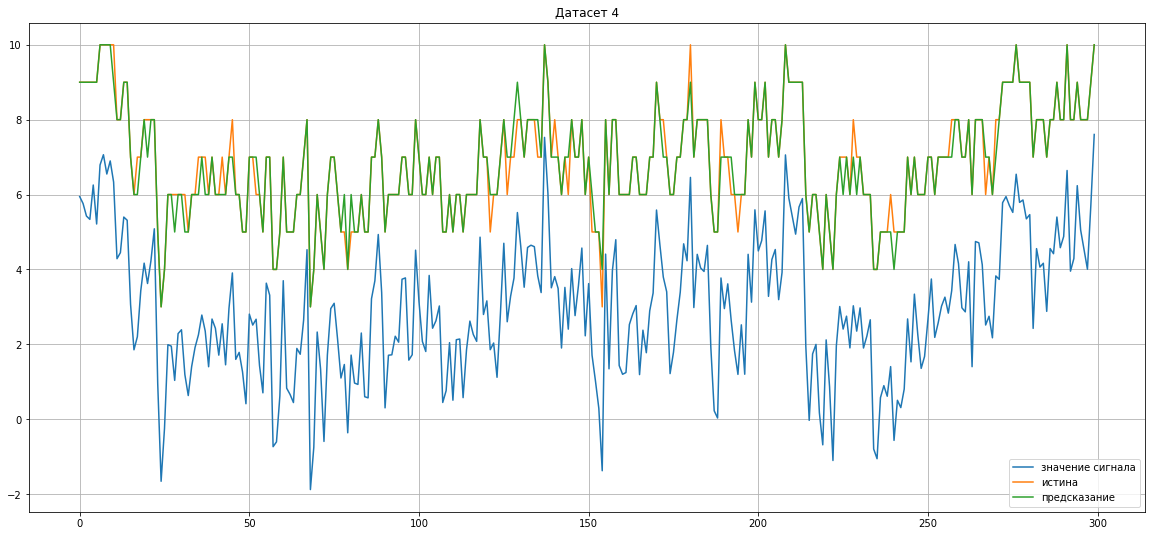

In [42]:
plt.figure(figsize=(20, 9))
cur_data = train_data[4].iloc[20000: 20000 + 300]
plt.plot(cur_data['signal'].values, label='значение сигнала')
plt.plot(cur_data['open_channels'].values, label='истина')
plt.plot(model_4.predict(PrepareData(cur_data['signal'].values)), label='предсказание')
plt.title('Датасет 4')
plt.grid()
plt.legend()
plt.show()

Видно, что мы не очень хорошо улавливаем степень изменения числа каналов при нижних и верхних пиках сигнала. Здесь нам поможет алгоритм scipy.signal.peak_prominences, который численно оценивает остроту пиков. Также добавим статистики по окнам разного размера и градиент массива.

Однако использование таких признаков на датасетах с малым числом возможных сигналов(например, 0 датасет из трейна, часть графика которого представлена ниже) может ухудшить результат. Для таких данных, где сигнал может сильно колебаться, а число каналов при этом вообще оставаться постоянным, стоит скорее не обращать особое внимание на пики, а наоборот сглаживать сигнал. Давайте попробуем рассмотреть разные фильтры сигналов. 

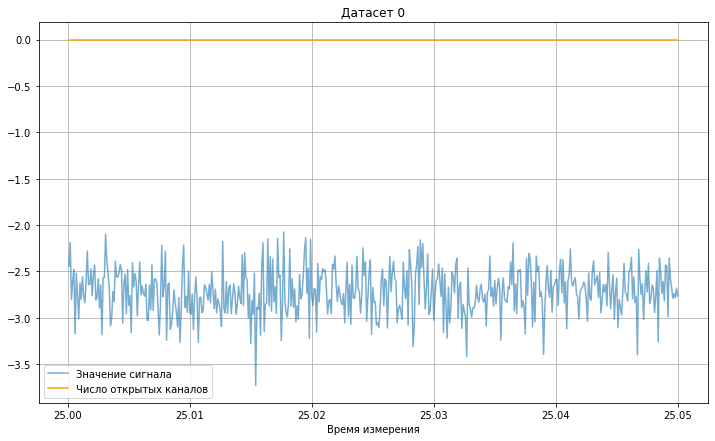

In [34]:
plt.figure(figsize=(12, 7))

plt.plot(train_data[0].index[250000: 250500],
             train_data[0]['signal'].iloc[250000: 250500],
             alpha=0.6, label='Значение сигнала')
plt.plot(train_data[0].index[250000: 250500],
         train_data[0]['open_channels'].iloc[250000: 250500], 
         c='orange', label='Число открытых каналов')

plt.xlabel('Время измерения')
plt.title(f'Датасет {0}')
plt.grid()
plt.legend()
plt.show()

**5. Фильтрация сигналов.**

Так как для некоторых датасетов малые колебания не влияют на изменения таргета, то давайте применим различные фильтры сигнала. Также разумно попробовать этот метод еще и потому, что в сигнал, как сказано в описании задачи, добавлен некоторый случайный шум(не путать с тем шумом-смещением, который мы ранее убрали), и фильтрация поможет в некоторой степени избавиться от него.

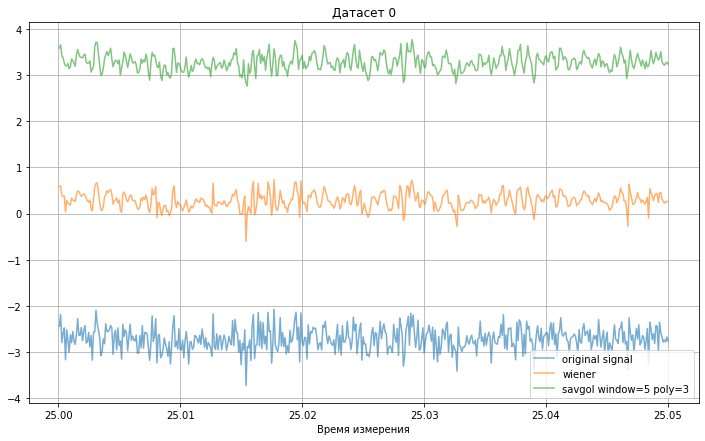

In [16]:
plt.figure(figsize=(12, 7))

plt.plot(train_data[0].index[250000: 250500],
         train_data[0]['signal'].iloc[250000: 250500],
         alpha=0.6, label='original signal')

plt.plot(train_data[0].index[250000: 250500],
         wiener(train_data[0]['signal'].iloc[250000: 250500]) + 3,
         alpha=0.6, label='wiener')

plt.plot(train_data[0].index[250000: 250500],
         savgol_filter(train_data[0]['signal'].iloc[250000: 250500], window_length=5, polyorder=3) + 6,
         alpha=0.6, label='savgol window=5 poly=3')


plt.xlabel('Время измерения')
plt.title(f'Датасет {0}')
plt.grid()
plt.legend()
plt.show()

На графике изображено то, как сглаживают сигнал два фильтра. Я пробовал и другие варианты, но визуально лучше всего себя ведут именно они.

In [14]:
def PrepareData(arr, 
                before=3,
                after=3,
                use_savgol=False,
                use_wiener=False,
                use_peaks=True,
                use_diffs=True):
    
    new_data = pd.DataFrame(index=np.arange(len(arr)))
    
    for j in range(1, after + 1):
        arr1 = np.repeat(-99999, j)
        arr2 = arr[j:] - arr[:-j]
        if use_diffs:
            cur_arr_diff = np.concatenate([arr1, arr2])
            new_data[f'signal diff {-j}'] = cur_arr_diff
        cur_arr = np.concatenate([arr1, arr[j:]])
        new_data[f'signal {j}'] = cur_arr
    
    new_data[f'signal {0}'] = arr

    for j in range(1, before + 1):
        arr1 = np.repeat(-99999, j)
        arr2 = arr[:-j] - arr[j:]
        if use_diffs:
            cur_arr_diff = np.concatenate([arr2, arr1])
            new_data[f'signal diff {j}'] = cur_arr_diff
        cur_arr = np.concatenate([arr1, arr[:-j]])
        new_data[f'signal {-j}'] = cur_arr
    
    windows = [5, 15, 45, 105, 1005]
    
    for window in windows:
        mean = pd.Series(arr).rolling(window, min_periods=1, center=True).mean()
        new_data[f'window {window} mean'] = mean
        
        min = pd.Series(arr).rolling(window, min_periods=1, center=True).min()
        new_data[f'window {window} min'] = min
        
        max = pd.Series(arr).rolling(window, min_periods=1, center=True).max()
        new_data[f'window {window} max'] = max
        
        median = pd.Series(arr).rolling(window, min_periods=1, center=True).median()
        new_data[f'window {window} median'] = median
        
        std = pd.Series(arr).rolling(window, min_periods=1, center=True).std()
        new_data[f'window {window} std'] = std
        
        dist = new_data[f'window {window} max'] - new_data[f'window {window} min'] 
        new_data[f'window {window} minmax dist'] = dist
    
    new_data['gradient'] = np.gradient(arr)
    
    if use_peaks:
        new_data['max_peak_prom'] = -999
        peaks, _ = find_peaks(arr)
        new_data['max_peak_prom'].iloc[peaks] = peak_prominences(arr, peaks)[0]

        new_data['min_peak_prom'] = -999
        peaks, _ = find_peaks(-arr)
        new_data['min_peak_prom'].iloc[peaks] = peak_prominences(-arr, peaks)[0]
    
    if use_savgol:
        new_data['savgol'] = savgol_filter(arr, window_length=5, polyorder=3)
    if use_wiener:
        new_data['wiener'] = wiener(arr)

    return new_data

Также в качестве модели я буду применять LGBMClassifier, потому что ранее использованный XGBClassifier обучается очень долго, что делает подбор оптимальной стратегии предсказания для него крайне накладным по времени. 

Будем экспериментировать с двумя подходами - либо сразу передавать генератору признаков отфильтрованный сигнал, либо отфильтрованный сигнал использовать в качестве признака. Так как у нас датасеты парные, то обучать модель будем на одном из них, а тестировать на другом.

*Тестирование фильтров на 0 и 1 датасетах*

In [66]:
Y_train = train_data[0]['open_channels'].values 
Y_test = train_data[1]['open_channels'].values

#изначальный сигнал без использования фильтров
X_train_original = PrepareData(train_data[0]['signal'].values) 
X_test_original = PrepareData(train_data[1]['signal'].values)

#фильтр wiener
X_train_wiener = PrepareData(wiener(train_data[0]['signal'].values)) 
X_test_wiener = PrepareData(wiener(train_data[1]['signal'].values))

#фильтр savgol
X_train_savgol = PrepareData(savgol_filter(train_data[0]['signal'].values,
                                           window_length=5, polyorder=3)) 
X_test_savgol = PrepareData(savgol_filter(train_data[1]['signal'].values,
                                          window_length=5, polyorder=3))

#изначальный сигнал с использованием savgol в качестве признака
X_train_original_savgol = PrepareData(train_data[0]['signal'].values, use_savgol=True) 
X_test_original_savgol = PrepareData(train_data[1]['signal'].values, use_savgol=True)

#изначальный сигнал с использованием wiener в качестве признака
X_train_original_wiener = PrepareData(train_data[0]['signal'].values, use_wiener=True) 
X_test_original_wiener = PrepareData(train_data[1]['signal'].values, use_wiener=True)

#изначальный сигнал с использованием wiener и savgol в качестве признаков
X_train_original_wiener_savgol = PrepareData(train_data[0]['signal'].values,
                                             use_wiener=True, use_savgol=True) 
X_test_original_wiener_savgol = PrepareData(train_data[1]['signal'].values,
                                            use_wiener=True, use_savgol=True)

#обучение моделей и вывод скора
model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original, Y_train)
score = f1_score(Y_test, model.predict(X_test_original), 
                 average="macro")
print(f'original: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_wiener), 
                 average="macro")
print(f'wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_savgol), 
                 average="macro")
print(f'savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener), 
                 average="macro")
print(f'original + wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener_savgol), 
                 average="macro")
print(f'original + wiener + savgol: score = {score}')

original: score = 0.9969197131804213
wiener: score = 0.9963665071504668
savgol: score = 0.9887978569716855
original + savgol: score = 0.9968657534493202
original + wiener: score = 0.9967979385428418
original + wiener + savgol: score = 0.9969460088032931


Лучший скор показала модель original + wiener + savgol. Я также сделал отбор признаков для нее и подобрал параметры модели. Получился такой скор:

In [85]:
X_train_original_wiener_savgol = PrepareData(train_data[0]['signal'].values,
                                             use_wiener=True, use_savgol=True,
                                             use_peaks=False) 
X_test_original_wiener_savgol = PrepareData(train_data[1]['signal'].values,
                                            use_wiener=True, use_savgol=True,
                                            use_peaks=False)

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener_savgol), 
                 average="macro")
print(f'original + wiener + savgol: score = {score}')

original + wiener + savgol: score = 0.9970134997685138


In [47]:
X = np.concatenate([train_data[0]['signal'].values, 
                    train_data[1]['signal'].values])
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
Y = np.concatenate([train_data[0]['open_channels'].values, 
                    train_data[1]['open_channels'].values])
model_1 = LGBMClassifier(n_estimators=50, max_depth=10)
model_1.fit(X, Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

*Тестирование фильтров на 2 и 6 датасетах*

In [113]:
Y_train = train_data[2]['open_channels'].values 
Y_test = train_data[6]['open_channels'].values

#изначальный сигнал без использования фильтров
X_train_original = PrepareData(train_data[2]['signal'].values) 
X_test_original = PrepareData(train_data[6]['signal'].values)

#фильтр wiener
X_train_wiener = PrepareData(wiener(train_data[2]['signal'].values)) 
X_test_wiener = PrepareData(wiener(train_data[6]['signal'].values))

#фильтр savgol
X_train_savgol = PrepareData(savgol_filter(train_data[2]['signal'].values,
                                           window_length=5, polyorder=3)) 
X_test_savgol = PrepareData(savgol_filter(train_data[6]['signal'].values,
                                          window_length=5, polyorder=3))

#изначальный сигнал с использованием savgol в качестве признака
X_train_original_savgol = PrepareData(train_data[2]['signal'].values, use_savgol=True) 
X_test_original_savgol = PrepareData(train_data[6]['signal'].values, use_savgol=True)

#изначальный сигнал с использованием wiener в качестве признака
X_train_original_wiener = PrepareData(train_data[2]['signal'].values, use_wiener=True) 
X_test_original_wiener = PrepareData(train_data[6]['signal'].values, use_wiener=True)

#изначальный сигнал с использованием wiener и savgol в качестве признаков
X_train_original_wiener_savgol = PrepareData(train_data[2]['signal'].values,
                                             use_wiener=True, use_savgol=True) 
X_test_original_wiener_savgol = PrepareData(train_data[6]['signal'].values,
                                            use_wiener=True, use_savgol=True)

#обучение моделей и вывод скора
model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original, Y_train)
score = f1_score(Y_test, model.predict(X_test_original), 
                 average="macro")
print(f'original: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_wiener), 
                 average="macro")
print(f'wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_savgol), 
                 average="macro")
print(f'savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener), 
                 average="macro")
print(f'original + wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener_savgol), 
                 average="macro")
print(f'original + wiener + savgol: score = {score}')

original: score = 0.9968753208392951
wiener: score = 0.995676830184528
savgol: score = 0.9874716412313673
original + savgol: score = 0.9968862998880674
original + wiener: score = 0.9968511723319949
original + wiener + savgol: score = 0.9968673853611253


Лучший скор показала модель original + savgol. Я также сделал отбор признаков для нее и подобрал параметры модели. Получился такой скор:

In [114]:
X_train_original_savgol = PrepareData(train_data[2]['signal'].values,
                                      use_savgol=True) 
X_test_original_savgol = PrepareData(train_data[6]['signal'].values,
                                     use_savgol=True)

model = LGBMClassifier(n_estimators=30, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

original + savgol: score = 0.99690215609505


In [33]:
X = np.concatenate([train_data[2]['signal'].values, 
                    train_data[6]['signal'].values])
X = PrepareData(X, use_savgol=True)

Y = np.concatenate([train_data[2]['open_channels'].values, 
                    train_data[6]['open_channels'].values])
model_2 = LGBMClassifier(n_estimators=30, max_depth=10)
model_2.fit(X, Y)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=30, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

*Тестирование фильтров на 3 и 7 датасетах*

In [115]:
Y_train = train_data[3]['open_channels'].values 
Y_test = train_data[7]['open_channels'].values

#изначальный сигнал без использования фильтров
X_train_original = PrepareData(train_data[3]['signal'].values) 
X_test_original = PrepareData(train_data[7]['signal'].values)

#фильтр wiener
X_train_wiener = PrepareData(wiener(train_data[3]['signal'].values)) 
X_test_wiener = PrepareData(wiener(train_data[7]['signal'].values))

#фильтр savgol
X_train_savgol = PrepareData(savgol_filter(train_data[3]['signal'].values,
                                           window_length=5, polyorder=3)) 
X_test_savgol = PrepareData(savgol_filter(train_data[7]['signal'].values,
                                          window_length=5, polyorder=3))

#изначальный сигнал с использованием savgol в качестве признака
X_train_original_savgol = PrepareData(train_data[3]['signal'].values, use_savgol=True) 
X_test_original_savgol = PrepareData(train_data[7]['signal'].values, use_savgol=True)

#изначальный сигнал с использованием wiener в качестве признака
X_train_original_wiener = PrepareData(train_data[3]['signal'].values, use_wiener=True) 
X_test_original_wiener = PrepareData(train_data[7]['signal'].values, use_wiener=True)

#изначальный сигнал с использованием wiener и savgol в качестве признаков
X_train_original_wiener_savgol = PrepareData(train_data[3]['signal'].values,
                                             use_wiener=True, use_savgol=True) 
X_test_original_wiener_savgol = PrepareData(train_data[7]['signal'].values,
                                            use_wiener=True, use_savgol=True)

#обучение моделей и вывод скора
model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original, Y_train)
score = f1_score(Y_test, model.predict(X_test_original), 
                 average="macro")
print(f'original: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_wiener), 
                 average="macro")
print(f'wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_savgol), 
                 average="macro")
print(f'savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener), 
                 average="macro")
print(f'original + wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener_savgol), 
                 average="macro")
print(f'original + wiener + savgol: score = {score}')

original: score = 0.9220055402576393
wiener: score = 0.8459085302673764
savgol: score = 0.8665078706869871
original + savgol: score = 0.9220669066698298
original + wiener: score = 0.9216149685810521
original + wiener + savgol: score = 0.9215330699302036


Лучший скор показала модель original + savgol. Я также сделал отбор признаков для нее и подобрал параметры модели. Получился такой скор:

In [127]:
X_train_original_savgol = PrepareData(train_data[3]['signal'].values,
                                      use_savgol=True, after=3, before=3) 
X_test_original_savgol = PrepareData(train_data[7]['signal'].values,
                                     use_savgol=True, after=3, before=3)

model = LGBMClassifier(n_estimators=60, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

original + savgol: score = 0.9222395070407381


In [34]:
X = np.concatenate([train_data[3]['signal'].values, 
                    train_data[7]['signal'].values])
X = PrepareData(X, use_savgol=True, after=3, before=3)

Y = np.concatenate([train_data[3]['open_channels'].values, 
                    train_data[7]['open_channels'].values])
model_3 = LGBMClassifier(n_estimators=60, max_depth=10)
model_3.fit(X, Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=60, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

*Тестирование фильтров на 4 и 9 датасетах*

In [62]:
Y_train = train_data[4]['open_channels'].values 
Y_test = train_data[9]['open_channels'].values

#изначальный сигнал без использования фильтров
X_train_original = PrepareData(train_data[4]['signal'].values) 
X_test_original = PrepareData(train_data[9]['signal'].values)

#фильтр wiener
X_train_wiener = PrepareData(wiener(train_data[4]['signal'].values)) 
X_test_wiener = PrepareData(wiener(train_data[9]['signal'].values))

#фильтр savgol
X_train_savgol = PrepareData(savgol_filter(train_data[4]['signal'].values,
                                           window_length=5, polyorder=3)) 
X_test_savgol = PrepareData(savgol_filter(train_data[9]['signal'].values,
                                          window_length=5, polyorder=3))

#изначальный сигнал с использованием savgol в качестве признака
X_train_original_savgol = PrepareData(train_data[4]['signal'].values, use_savgol=True) 
X_test_original_savgol = PrepareData(train_data[9]['signal'].values, use_savgol=True)

#изначальный сигнал с использованием wiener в качестве признака
X_train_original_wiener = PrepareData(train_data[4]['signal'].values, use_wiener=True) 
X_test_original_wiener = PrepareData(train_data[9]['signal'].values, use_wiener=True)

#изначальный сигнал с использованием wiener и savgol в качестве признаков
X_train_original_wiener_savgol = PrepareData(train_data[4]['signal'].values,
                                             use_wiener=True, use_savgol=True) 
X_test_original_wiener_savgol = PrepareData(train_data[9]['signal'].values,
                                            use_wiener=True, use_savgol=True)

#обучение моделей и вывод скора
model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original, Y_train)
score = f1_score(Y_test, model.predict(X_test_original), 
                 average="macro")
print(f'original: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_wiener), 
                 average="macro")
print(f'wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_savgol), 
                 average="macro")
print(f'savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener), 
                 average="macro")
print(f'original + wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener_savgol), 
                 average="macro")
print(f'original + wiener + savgol: score = {score}')

original: score = 0.6478828609511894
wiener: score = 0.5540341115811311
savgol: score = 0.521301229374902
original + savgol: score = 0.7171169592017688
original + wiener: score = 0.6662237017640682
original + wiener + savgol: score = 0.6579908407049879


Лучший скор показала модель original + savgol. Я также сделал отбор признаков для нее и подобрал параметры модели. Получился такой скор: 

In [63]:
X_train_original_savgol = PrepareData(train_data[4]['signal'].values,
                                      use_savgol=True) 
X_test_original_savgol = PrepareData(train_data[9]['signal'].values,
                                     use_savgol=True)

model = LGBMClassifier(n_estimators=200, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

original + savgol: score = 0.6009615313061303


In [64]:
X = np.concatenate([train_data[4]['signal'].values, 
                    train_data[9]['signal'].values])
X = PrepareData(X, use_savgol=True)

Y = np.concatenate([train_data[4]['open_channels'].values, 
                    train_data[9]['open_channels'].values])
model_4 = LGBMClassifier(n_estimators=200, max_depth=10)
model_4.fit(X, Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

*Тестирование фильтров на 5 и 8 датасетах*

In [22]:
Y_train = train_data[5]['open_channels'].values 
Y_test = train_data[8]['open_channels'].values

#изначальный сигнал без использования фильтров
X_train_original = PrepareData(train_data[5]['signal'].values) 
X_test_original = PrepareData(train_data[8]['signal'].values)

#фильтр wiener
X_train_wiener = PrepareData(wiener(train_data[5]['signal'].values)) 
X_test_wiener = PrepareData(wiener(train_data[8]['signal'].values))

#фильтр savgol
X_train_savgol = PrepareData(savgol_filter(train_data[5]['signal'].values,
                                           window_length=5, polyorder=3)) 
X_test_savgol = PrepareData(savgol_filter(train_data[8]['signal'].values,
                                          window_length=5, polyorder=3))

#изначальный сигнал с использованием savgol в качестве признака
X_train_original_savgol = PrepareData(train_data[5]['signal'].values, use_savgol=True) 
X_test_original_savgol = PrepareData(train_data[8]['signal'].values, use_savgol=True)

#изначальный сигнал с использованием wiener в качестве признака
X_train_original_wiener = PrepareData(train_data[5]['signal'].values, use_wiener=True) 
X_test_original_wiener = PrepareData(train_data[8]['signal'].values, use_wiener=True)

#изначальный сигнал с использованием wiener и savgol в качестве признаков
X_train_original_wiener_savgol = PrepareData(train_data[5]['signal'].values,
                                             use_wiener=True, use_savgol=True) 
X_test_original_wiener_savgol = PrepareData(train_data[8]['signal'].values,
                                            use_wiener=True, use_savgol=True)

#обучение моделей и вывод скора
model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original, Y_train)
score = f1_score(Y_test, model.predict(X_test_original), 
                 average="macro")
print(f'original: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_wiener), 
                 average="macro")
print(f'wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_savgol), 
                 average="macro")
print(f'savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_savgol), 
                 average="macro")
print(f'original + savgol: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener), 
                 average="macro")
print(f'original + wiener: score = {score}')

model = LGBMClassifier(n_estimators=50, max_depth=10)
model.fit(X_train_original_wiener_savgol, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener_savgol), 
                 average="macro")
print(f'original + wiener + savgol: score = {score}')

original: score = 0.9384725111713322
wiener: score = 0.8723852085195314
savgol: score = 0.8163775618031023
original + savgol: score = 0.9348352141221353
original + wiener: score = 0.9387989325047067
original + wiener + savgol: score = 0.935259550544434


Лучший скор показала модель original + wiener. Я также сделал отбор признаков для нее и подобрал параметры модели. Получился такой скор: 

In [30]:
X_train_original_wiener = PrepareData(train_data[5]['signal'].values,
                                      use_wiener=True, after=3, before=3, use_peaks=False) 
X_test_original_wiener = PrepareData(train_data[8]['signal'].values,
                                     use_wiener=True, after=3, before=3, use_peaks=False)

model = LGBMClassifier(n_estimators=30, max_depth=10)
model.fit(X_train_original_wiener, Y_train)
score = f1_score(Y_test, model.predict(X_test_original_wiener), 
                 average="macro")
print(f'original + wiener: score = {score}')

original + wiener: score = 0.9450173275826197


In [31]:
X = np.concatenate([train_data[5]['signal'].values, 
                    train_data[8]['signal'].values])
X = PrepareData(X, use_wiener=True, after=3, before=3, use_peaks=False) 
Y = np.concatenate([train_data[5]['open_channels'].values, 
                    train_data[8]['open_channels'].values])
model_5 = LGBMClassifier(n_estimators=30, max_depth=10)
model_5.fit(X, Y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=30, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
predictions = np.array([])

#датасет 0
X = test_data[0].loc[:10, 'signal'].values
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[10.0001:20, 'signal'].values
X = PrepareData(X, use_savgol=True, after=3, before=3)
predictions = np.append(predictions, model_3.predict(X))

X = test_data[0].loc[20.0001:30, 'signal'].values
X = PrepareData(X, use_wiener=True, after=3, before=3, use_peaks=False) 
predictions = np.append(predictions, model_5.predict(X))

X = test_data[0].loc[30.0001:40, 'signal'].values
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[40.0001:, 'signal'].values
X = PrepareData(X, use_savgol=True)
predictions = np.append(predictions, model_2.predict(X))

#датасет 1
X = test_data[1].loc[:10, 'signal'].values
X = PrepareData(X, use_savgol=True, after=3, before=3)
predictions = np.append(predictions, model_4.predict(X))

X = test_data[1].loc[10.0001:30, 'signal'].values
X = PrepareData(X, use_wiener=True, after=3, before=3, use_peaks=False) 
predictions = np.append(predictions, model_5.predict(X))

X = test_data[1].loc[30.0001:40, 'signal'].values
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[1].loc[40.0001:, 'signal'].values
X = PrepareData(X, use_savgol=True, after=3, before=3)
predictions = np.append(predictions, model_3.predict(X))

#датасеты 2 и 3
X = np.concatenate([test_data[2]['signal'].values,
                    test_data[3]['signal'].values])
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

In [38]:
f = lambda x: '{:,.4f}'.format(x)
vf = np.vectorize(f)

ans = pd.DataFrame({'time': vf(test_data_index),
                    'open_channels': predictions.astype('int32')})

ans.to_csv('ion_v24.csv', index=False)

К сожалению, мы получили скор всего 0.937. Скорее всего, это произошло из-за недообученности наших моделей. Возможно, нужно было использовать меньший по размеру тест, а не целый датасет в качестве теста. Давайте попробуем теперь использовать одну модель для всех датасетов - XGBClassifier(n_estimators=100, max_depth=10). При этом будем использовать те признаки и виды фильтров, которые только что отобрали для каждого датасета.

In [15]:
X = np.concatenate([train_data[0]['signal'].values, 
                    train_data[1]['signal'].values])
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
Y = np.concatenate([train_data[0]['open_channels'].values, 
                    train_data[1]['open_channels'].values])
model_1 = XGBClassifier(n_estimators=100, max_depth=10)
model_1.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [16]:
X = np.concatenate([train_data[2]['signal'].values, 
                    train_data[6]['signal'].values])
X = PrepareData(X, use_savgol=True)

Y = np.concatenate([train_data[2]['open_channels'].values, 
                    train_data[6]['open_channels'].values])
model_2 = XGBClassifier(n_estimators=100, max_depth=10)
model_2.fit(X, Y)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [17]:
X = np.concatenate([train_data[3]['signal'].values, 
                    train_data[7]['signal'].values])
X = PrepareData(X, use_savgol=True, after=3, before=3)

Y = np.concatenate([train_data[3]['open_channels'].values, 
                    train_data[7]['open_channels'].values])
model_3 = XGBClassifier(n_estimators=100, max_depth=10)
model_3.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
X = np.concatenate([train_data[4]['signal'].values, 
                    train_data[9]['signal'].values])
X = PrepareData(X, use_savgol=True)

Y = np.concatenate([train_data[4]['open_channels'].values, 
                    train_data[9]['open_channels'].values])
model_4 = XGBClassifier(n_estimators=100, max_depth=10)
model_4.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
X = np.concatenate([train_data[5]['signal'].values, 
                    train_data[8]['signal'].values])
X = PrepareData(X, use_wiener=True, after=3, before=3, use_peaks=False) 
Y = np.concatenate([train_data[5]['open_channels'].values, 
                    train_data[8]['open_channels'].values])
model_5 = XGBClassifier(n_estimators=100, max_depth=10)
model_5.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
predictions = np.array([])

#датасет 0
X = test_data[0].loc[:10, 'signal'].values
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[10.0001:20, 'signal'].values
X = PrepareData(X, use_savgol=True, after=3, before=3)
predictions = np.append(predictions, model_3.predict(X))

X = test_data[0].loc[20.0001:30, 'signal'].values
X = PrepareData(X, use_wiener=True, after=3, before=3, use_peaks=False) 
predictions = np.append(predictions, model_5.predict(X))

X = test_data[0].loc[30.0001:40, 'signal'].values
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[0].loc[40.0001:, 'signal'].values
X = PrepareData(X, use_savgol=True)
predictions = np.append(predictions, model_2.predict(X))

#датасет 1
X = test_data[1].loc[:10, 'signal'].values
X = PrepareData(X, use_savgol=True, after=3, before=3)
predictions = np.append(predictions, model_4.predict(X))

X = test_data[1].loc[10.0001:30, 'signal'].values
X = PrepareData(X, use_wiener=True, after=3, before=3, use_peaks=False) 
predictions = np.append(predictions, model_5.predict(X))

X = test_data[1].loc[30.0001:40, 'signal'].values
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

X = test_data[1].loc[40.0001:, 'signal'].values
X = PrepareData(X, use_savgol=True, after=3, before=3)
predictions = np.append(predictions, model_3.predict(X))

#датасеты 2 и 3
X = np.concatenate([test_data[2]['signal'].values,
                    test_data[3]['signal'].values])
X = PrepareData(X, use_wiener=True, use_savgol=True,
                use_peaks=False)
predictions = np.append(predictions, model_1.predict(X))

In [21]:
f = lambda x: '{:,.4f}'.format(x)
vf = np.vectorize(f)

ans = pd.DataFrame({'time': vf(test_data_index),
                    'open_channels': predictions.astype('int32')})

ans.to_csv('ion_v26.csv', index=False)

Мы получили скор = 0.939

**Вывод:** Мы получили довольно неплохой скор. Работа с сигналом, выявление и удаление добавленного шума, разделение данных по характеру сигнала, генерация полезных признаков дали свои плоды. Я думаю, над задачей можно продолжать работать. Например, применить более сложные фильтры сигналов, использовать преобразования ряда. Можно попробовать использовать продвинутые варианты нейросетей.